## Configuration

This cell contains all key parameters for analysis. To replicate the paper's results, run this cell and "Run All".

In [222]:
# Standard Imports
import pandas as pd
import numpy as np
import os
import time
import joblib

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier as HGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import pointbiserialr
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import brier_score_loss, make_scorer, average_precision_score, log_loss, matthews_corrcoef
from sklearn.base import clone
from scipy.special import expit
import statsmodels.api as sm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


# Google Drive Mounting and Paths
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/Diffusion_Indices_Project/"
INTERMEDIATE_PATH = os.path.join(BASE_PATH, "03_intermediate_data")
RESULTS_PATH = os.path.join(BASE_PATH, "04_results")
OOS_PRED_PATH = os.path.join(RESULTS_PATH, "oos_predictions")
SUB_INDICES_PATH = os.path.join(RESULTS_PATH, 'sub_indices_for_tuning')
os.makedirs(SUB_INDICES_PATH, exist_ok=True)

# Create the results directories if they don't exist
os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(OOS_PRED_PATH, exist_ok=True)

# Out-of-sample (OOS) Loop Settings
OOS_START_DATE = '1990-01-01'
PREDICTION_HORIZONS = [1, 3]
LAGS_TO_ADD = [1, 2, 3, 6, 9, 12]


# These are the five models used to generate the ensemble forecasts
MODELS_TO_RUN = {
    'Logit': LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42),
    'Logit_L1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
    'HGBoost': HGBoost(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Rerun Control
# Set to True to delete and regenerate all results files.
FORCE_RERUN_ALL_SETS = False
FORCE_RERUN_SPECIFIC_SETS = ['Deter'] # This is ignored if the RERUN_ALL_SETS is True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

The following steps load data from the original notebook that preprocesses data.

In [213]:
import warnings
warnings.filterwarnings("ignore")

In [214]:
print("Loading analysis-ready datasets...")
y_target_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'y_target.pkl'))
X_yield_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'X_yield.pkl'))
X_transformed_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'X_transformed_monthly.pkl'))
X_untransformed_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'X_untransformed_monthly.pkl'))
X_ads_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'X_ads.pkl'))
tcodes = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'tcodes.pkl'))

print("All data loaded successfully.")
print(f"Data shape: {X_transformed_full.shape}, Target shape: {y_target_full.shape}")

Loading analysis-ready datasets...
All data loaded successfully.
Data shape: (780, 126), Target shape: (780, 1)


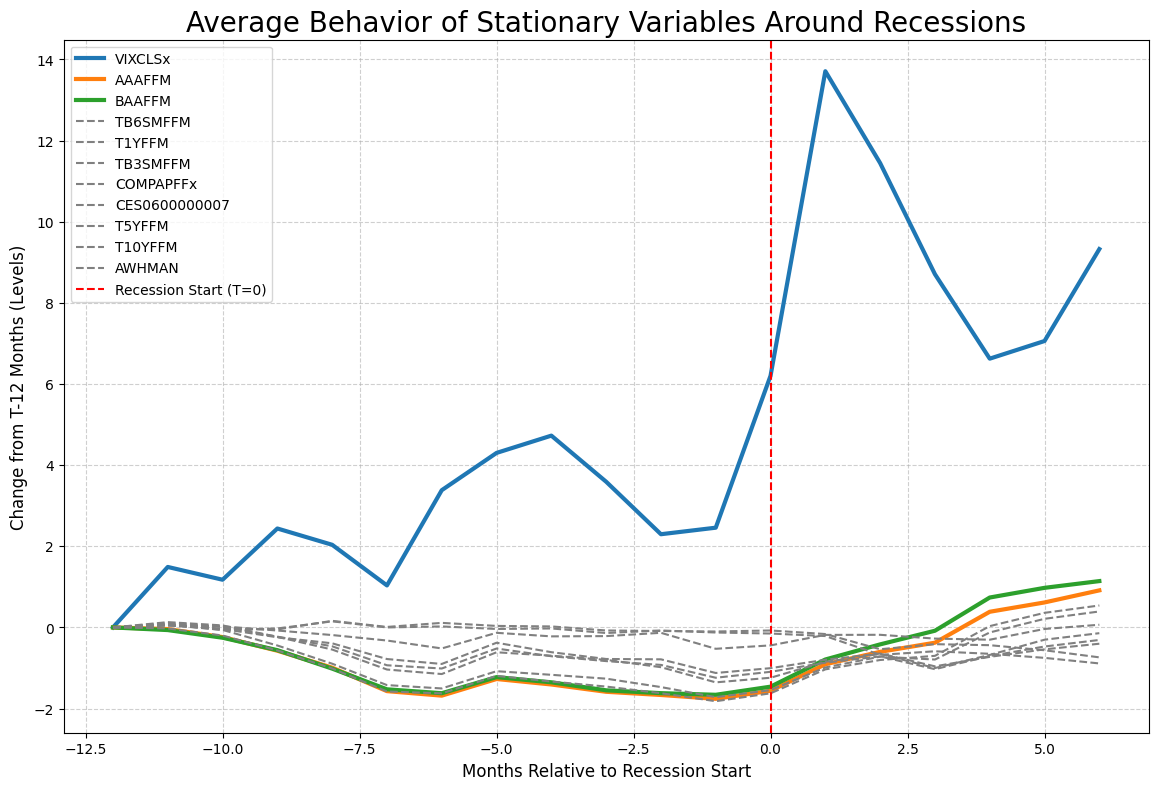

In [215]:
# analyzing erratic behavior of tcode1 variables
tcode1_vars = ['TB6SMFFM', 'VIXCLSx', 'T1YFFM', 'TB3SMFFM', 'COMPAPFFx',
               'CES0600000007', 'T5YFFM', 'T10YFFM', 'AWHMAN', 'AAAFFM', 'BAAFFM']

data = X_untransformed_full
y_target = y_target_full

recession_starts = y_target[y_target['USRECM'].diff() == 1].index

window_before = 12
window_after = 6
all_events = []

for start_date in recession_starts:
    try:
        start_loc = data.index.get_loc(start_date)

        if start_loc >= window_before:
            event_window = data.iloc[start_loc - window_before : start_loc + window_after + 1]

            if event_window.empty:
                continue

            normalized_window = event_window - event_window.iloc[0]

            normalized_window.index = np.arange(-window_before, window_after + 1)
            all_events.append(normalized_window)

    except KeyError:

        print(f"Recession start date {start_date} not found in data index. Skipping.")
        continue

if not all_events:
    print("Could not generate event study plot: No recessions with a full historical window were found in the sample.")
else:
    # Average the trajectories
    average_event_trajectory = pd.concat(all_events).groupby(level=0).mean()

    fig, ax = plt.subplots(figsize=(14, 9))

    special_vars = ['VIXCLSx', 'AAAFFM', 'BAAFFM']
    other_vars = [v for v in tcode1_vars if v not in special_vars]

    average_event_trajectory[special_vars].plot(ax=ax, linewidth=3)
    average_event_trajectory[other_vars].plot(ax=ax, style='--', color='grey', linewidth=1.5, legend=False)

    ax.axvline(x=0, color='red', linestyle='--', label='Recession Start (T=0)')
    ax.set_title('Average Behavior of Stationary Variables Around Recessions', fontsize=20)
    ax.set_xlabel('Months Relative to Recession Start', fontsize=12)
    ax.set_ylabel('Change from T-12 Months (Levels)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

    plt.show()

In [216]:
# modeling interaction between real and fin to justify diffs for credit spreads
spread_vars = ['AAAFFM', 'BAAFFM', 'TB6SMFFM', 'T1YFFM', 'TB3SMFFM', 'COMPAPFFx', 'T5YFFM', 'T10YFFM']


in_sample_spreads = X_untransformed_full.loc[:'1989-12-31', spread_vars]


real_economy_indicator = np.log(X_untransformed_full['INDPRO']).diff().loc[:'1989-12-31']

results = []
for var in spread_vars:
    level = in_sample_spreads[var]
    change = in_sample_spreads[var].diff()


    corr_level = pd.concat([real_economy_indicator, level], axis=1).dropna().corr().iloc[0, 1]
    corr_change = pd.concat([real_economy_indicator, change], axis=1).dropna().corr().iloc[0, 1]

    # A high ratio means the "change" is more informative about the real economy
    if abs(corr_level) > 0:
        ratio = abs(corr_change) / abs(corr_level)
    else:
        ratio = np.nan

    results.append({'Variable': var, 'Corr_Level': corr_level, 'Corr_Change': corr_change, 'Ratio': ratio})


results_df = pd.DataFrame(results).set_index('Variable')
print("Contagion Correlation Ratio (Change vs. Level with INDPRO Growth)")
print(results_df.sort_values(by='Ratio', ascending=False))

Contagion Correlation Ratio (Change vs. Level with INDPRO Growth)
           Corr_Level  Corr_Change     Ratio
Variable                                    
BAAFFM       0.108426    -0.302430  2.789264
AAAFFM       0.181474    -0.272955  1.504099
T10YFFM      0.207870    -0.246394  1.185327
T5YFFM       0.208670    -0.217581  1.042705
TB3SMFFM     0.294387    -0.166088  0.564183
TB6SMFFM     0.283415    -0.154789  0.546155
T1YFFM       0.252499    -0.129369  0.512353
COMPAPFFx    0.174450    -0.056686  0.324941


## Predictor Set Generation

Includes functions for selecting top variables per category, then creating index (two factor, just weakness, just deterioration).

In [217]:
lasso_weights_cache = {}

def select_top_variables_per_category(X_data, y_data, variable_groups, horizon, top_n=10, corr_threshold=0.1):
    """
    Selects the top N variables per category based on correlation.
    """
    print("      -> Selecting top variables per category (Strict Top-N)...")

    y_shifted = y_data.shift(-horizon)
    y_shifted.name = 'y_lead'

    aligned_data = pd.concat([y_shifted, X_data], axis=1).dropna()
    y_aligned = aligned_data['y_lead']
    X_aligned = aligned_data.drop(columns=['y_lead'])

    if len(y_aligned.unique()) < 2:
        return {cat: vars[:top_n] for cat, vars in variable_groups.items()} # Fallback

    refined_groups = {}
    for category, var_list in variable_groups.items():
        var_scores = {}
        for var in var_list:
            if var in X_aligned.columns:
                try:
                    correlation, _ = pointbiserialr(X_aligned[var], y_aligned)
                    if not np.isnan(correlation) and abs(correlation) >= corr_threshold:
                        var_scores[var] = abs(correlation)
                except ValueError:
                    continue

        # Sort variables by score
        sorted_vars = sorted(var_scores.items(), key=lambda x: x[1], reverse=True)


        # Extract only the names of the top N variables
        top_var_names = [var for var, score in sorted_vars[:top_n]]


        if top_var_names:
            refined_groups[category] = top_var_names # Store the list of names

    return refined_groups


def generate_PCA_Factors(X_transformed_train, n_factors=8):
    """
    Returns the top PCA factors.
    """
    print("      -> Generating PCA Factors...")

    # Drop columns that are entirely NaN in the CURRENT training slice
    X_stat = X_transformed_train.copy()
    cols_to_drop_nan = X_stat.columns[X_stat.isna().all()]
    if not cols_to_drop_nan.empty:
        print(f"\n         ... Dropping {len(cols_to_drop_nan)} all-NaN columns: {cols_to_drop_nan.to_list()}", end="")
    X_stat_valid = X_stat.drop(columns=cols_to_drop_nan)


    # Imputation. Now guaranteed to have matching shapes
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = pd.DataFrame(imputer.fit_transform(X_stat_valid),
                             index=X_stat_valid.index,
                             columns=X_stat_valid.columns)

    # Standardization
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed),
                            index=X_imputed.index,
                            columns=X_imputed.columns)

    # Drop constant columns AFTER scaling (a final check)
    variances = X_scaled.var()
    constant_cols = variances[variances < 1e-10].index
    if not constant_cols.empty:
        print(f"\n         ... Dropping {len(constant_cols)} constant columns: {constant_cols.to_list()}", end="")
    X_final_for_pca = X_scaled.drop(columns=constant_cols)


    # PCA on the final, clean data
    pca = PCA(n_components=n_factors)
    factors = pca.fit_transform(X_final_for_pca)

    pca_factors_df = pd.DataFrame(factors,
                                  index=X_final_for_pca.index,
                                  columns=[f'PCA_Factor_{i+1}' for i in range(n_factors)])

    return pca_factors_df

def generate_Targeted_PCA_Factors(X_transformed_train, selected_vars, n_factors=8):
    """
    Returns the top PCA factors.
    """
    print("      -> Generating Targeted PCA Factors...")
    X_subset = X_transformed_train[selected_vars]

    # Drop columns that are entirely NaN in the CURRENT training slice
    X_stat = X_subset.copy()
    cols_to_drop_nan = X_stat.columns[X_stat.isna().all()]
    if not cols_to_drop_nan.empty:
        print(f"\n         ... Dropping {len(cols_to_drop_nan)} all-NaN columns: {cols_to_drop_nan.to_list()}", end="")
    X_stat_valid = X_stat.drop(columns=cols_to_drop_nan)

    # Imputation. Now guaranteed to have matching shapes
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = pd.DataFrame(imputer.fit_transform(X_stat_valid),
                             index=X_stat_valid.index,
                             columns=X_stat_valid.columns)

    # Standardization
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed),
                            index=X_imputed.index,
                            columns=X_imputed.columns)

    # Drop constant columns AFTER scaling (a final check)
    variances = X_scaled.var()
    constant_cols = variances[variances < 1e-10].index
    if not constant_cols.empty:
        print(f"\n         ... Dropping {len(constant_cols)} constant columns: {constant_cols.to_list()}", end="")
    X_final_for_pca = X_scaled.drop(columns=constant_cols)


    # PCA on the final, clean data
    pca = PCA(n_components=n_factors)
    factors = pca.fit_transform(X_final_for_pca)

    pca_factors_df = pd.DataFrame(factors,
                                  index=X_final_for_pca.index,
                                  columns=[f'PCA_Factor_{i+1}' for i in range(n_factors)])
    return pca_factors_df

def generate_TFDI_Sub_Indices(X_transformed_train, y_train, horizon):
    """
    This is the TDFI framework. It uses Ridge (L2) for nowcasting (h<3)
    to retain all signals, and LASSO (L1) for forecasting (h>=3) to perform
    automated feature selection and remove noise.
    """
    print(f"      -> Generating TFDI (h={horizon})...")

    # Generate Unweighted Sub-Indices
    variable_groups = {
        'Output_Income': ['RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS'],
        'Labor_Market': ['HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008'],
        'Housing': ['HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW'],
        'Consumption_Orders_Inventories': ['DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx'],
        'Money_Credit': ['M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST'],
        'Interest_Rates_Spreads': ['FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM'],
        'FX_Rates': ['EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx'],
        'Prices': ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'],
        'Stock_Market': ['S&P 500', 'S&P div yield', 'S&P PE ratio', 'VIXCLSx']
    }
    counter_cyclical_vars = {'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'ISRATIOx', 'AAAFFM', 'BAAFFM', 'VIXCLSx'}
    special_financial_vars = {'AAAFFM', 'BAAFFM', 'VIXCLSx'}
    X_momentum = X_transformed_train.rolling(window=3, min_periods=1).mean()
    # refined_variable_groups = select_top_variables_per_category(X_momentum, y_train, variable_groups, horizon=horizon, top_n=10)
    refined_variable_groups = variable_groups

    adaptive_window = 180
    weakness_states = pd.DataFrame(index=X_transformed_train.index)
    deterioration_states = pd.DataFrame(index=X_transformed_train.index)


    all_selected_vars = [var for var_list in refined_variable_groups.values() for var in var_list]
    for var in all_selected_vars:
        signal_for_ranking = X_transformed_train[var]
        is_counter_theoretical = var in counter_cyclical_vars
        use_counter_logic = is_counter_theoretical

        if horizon == 1 and var in special_financial_vars:
            use_counter_logic = True
            signal_for_ranking = X_transformed_train[var].diff()
        elif horizon > 1 and var in special_financial_vars:
            signal_for_ranking = X_transformed_train[var].diff()

        level_signal = signal_for_ranking
        momentum_signal = signal_for_ranking.rolling(window=3, min_periods=1).mean()


        weakness_threshold = level_signal.quantile(0.8 if use_counter_logic else 0.2)
        weak_state = pd.Series(0.0, index=level_signal.index)
        if use_counter_logic: weak_state[level_signal > weakness_threshold] = 1.0
        else: weak_state[level_signal < weakness_threshold] = 1.0
        weakness_states[var] = weak_state

        deterioration_threshold = momentum_signal.quantile(0.8 if use_counter_logic else 0.2)
        deteriorating_state = pd.Series(0.0, index=momentum_signal.index)
        if use_counter_logic: deteriorating_state[momentum_signal > deterioration_threshold] = 1.0
        else: deteriorating_state[momentum_signal < deterioration_threshold] = 1.0
        deterioration_states[var] = deteriorating_state


    # Aggregate into Unweighted Per-Category Sub-Indices
    cat_weakness_di = pd.DataFrame(index=X_transformed_train.index)
    cat_deterioration_di = pd.DataFrame(index=X_transformed_train.index)

    for category, var_list in refined_variable_groups.items():
        # Only try to access columns that were actually selected
        weak_cols = [v for v in var_list if v in weakness_states.columns]
        if weak_cols:
            cat_weakness_di[f"W_{category.replace(' ', '_')}"] = weakness_states[weak_cols].mean(axis=1)

        det_cols = [v for v in var_list if v in deterioration_states.columns]
        if det_cols:
            cat_deterioration_di[f"D_{category.replace(' ', '_')}"] = deterioration_states[det_cols].mean(axis=1)


    all_sub_indices = pd.concat([cat_weakness_di, cat_deterioration_di], axis=1)
    # Weighting step
    y_shifted = y_train.shift(-horizon).rename('y_lead')
    weighting_data = pd.concat([y_shifted, all_sub_indices], axis=1, join='inner').dropna()
    y_weight = weighting_data['y_lead']
    X_weight = weighting_data.drop(columns=['y_lead'])

    weights = pd.Series(1.0, index=X_weight.columns) # Default to equal weights

    if len(y_weight.unique()) == 2 and not X_weight.empty:


        if horizon < 3:
            print("         ... using LASSO (L1) weighting for forecasting.")
            model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, C=0.1)
            param_grid = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
        else:
            print("         ... using LASSO (L1) weighting for forecasting.")
            model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, C=0.1)
            param_grid = {'C': [1.0, 0.5, 0.1, 0.05, 0.01]}

        # Not fitting gridsearch because tuning does worse
        model.fit(X_weight, y_weight)
        weights = pd.Series(np.abs(model.coef_[0]), index=X_weight.columns)

    return all_sub_indices.mul(weights).fillna(method='ffill').fillna(0)

def generate_Weakness_Indices(X_transformed_train, y_train, horizon):
    """
    This is the final, unified framework. It uses Ridge (L2) for nowcasting (h<3)
    to retain all signals, and LASSO (L1) for forecasting (h>=3) to perform
    automated feature selection and remove noise.
    """
    print(f"      -> Generating TFDI Weakness Indices (h={horizon})...")


    variable_groups = {
        'Output_Income': ['RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS'],
        'Labor_Market': ['HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008'],
        'Housing': ['HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW'],
        'Consumption_Orders_Inventories': ['DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx'],
        'Money_Credit': ['M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST'],
        'Interest_Rates_Spreads': ['FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM'],
        'FX_Rates': ['EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx'],
        'Prices': ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'],
        'Stock_Market': ['S&P 500', 'S&P div yield', 'S&P PE ratio', 'VIXCLSx']
    }
    counter_cyclical_vars = {'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'ISRATIOx', 'AAAFFM', 'BAAFFM', 'VIXCLSx'}
    special_financial_vars = {'AAAFFM', 'BAAFFM', 'VIXCLSx'}
    X_momentum = X_transformed_train.rolling(window=3, min_periods=1).mean()
    # refined_variable_groups = select_top_variables_per_category(X_momentum, y_train, variable_groups, horizon=horizon, top_n=10)
    refined_variable_groups = variable_groups
    adaptive_window = 180

    weakness_states = pd.DataFrame(index=X_transformed_train.index)
    deterioration_states = pd.DataFrame(index=X_transformed_train.index)

    all_selected_vars = [var for var_list in refined_variable_groups.values() for var in var_list]
    for var in all_selected_vars:
        signal_for_ranking = X_transformed_train[var]
        is_counter_theoretical = var in counter_cyclical_vars
        use_counter_logic = is_counter_theoretical

        if horizon == 1 and var in special_financial_vars:
            use_counter_logic = True
            signal_for_ranking = X_transformed_train[var].diff()
        elif horizon > 1 and var in special_financial_vars:
            signal_for_ranking = X_transformed_train[var].diff()

        level_signal = signal_for_ranking
        momentum_signal = signal_for_ranking.rolling(window=3, min_periods=1).mean()


        weakness_threshold = level_signal.rolling(window=adaptive_window, min_periods=36).quantile(0.8 if use_counter_logic else 0.2)
        weak_state = pd.Series(0.0, index=level_signal.index)
        if use_counter_logic: weak_state[level_signal > weakness_threshold] = 1.0
        else: weak_state[level_signal < weakness_threshold] = 1.0
        weakness_states[var] = weak_state


    # Perform same operations as original function but only for Weakness
    cat_weakness_di = pd.DataFrame(index=X_transformed_train.index)

    for category, var_list in refined_variable_groups.items():

        weak_cols = [v for v in var_list if v in weakness_states.columns]
        if weak_cols:
            cat_weakness_di[f"W_{category.replace(' ', '_')}"] = weakness_states[weak_cols].mean(axis=1)



    all_sub_indices = cat_weakness_di

    y_shifted = y_train.shift(-horizon).rename('y_lead')
    weighting_data = pd.concat([y_shifted, all_sub_indices], axis=1, join='inner').dropna()
    y_weight = weighting_data['y_lead']
    X_weight = weighting_data.drop(columns=['y_lead'])

    weights = pd.Series(1.0, index=X_weight.columns) # Default to equal weights

    if len(y_weight.unique()) == 2 and not X_weight.empty:



        if horizon < 3:
            print("         ... using LASSO (L2) weighting for forecasting.")
            model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, C=0.1)
            param_grid = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
        else:
            print("         ... using LASSO (L1) weighting for forecasting.")
            model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42, C=0.1)
            param_grid = {'C': [1.0, 0.5, 0.1, 0.05, 0.01]}

        # Not fitting gridsearch because tuning does worse
        model.fit(X_weight, y_weight)
        weights = pd.Series(np.abs(model.coef_[0]), index=X_weight.columns)


    return all_sub_indices.mul(weights).fillna(method='ffill').fillna(0)


def generate_Deter_Indices(X_transformed_train, y_train, horizon):
    """
    This is the final, unified framework. It uses Ridge (L2) for nowcasting (h<3)
    to retain all signals, and LASSO (L1) for forecasting (h>=3) to perform
    automated feature selection and remove noise.
    """
    print(f"      -> Generating Deterioration Indices (h={horizon})...")

    variable_groups = {
        'Output_Income': ['RPI', 'W875RX1', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS'],
        'Labor_Market': ['HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'CES0600000008', 'CES2000000008', 'CES3000000008'],
        'Housing': ['HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW'],
        'Consumption_Orders_Inventories': ['DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx'],
        'Money_Credit': ['M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST'],
        'Interest_Rates_Spreads': ['FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM', 'T10YFFM', 'AAAFFM', 'BAAFFM', 'EXSZUSx', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx'],
        'Prices': ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'],
        'Stock_Market': ['S&P 500', 'S&P div yield', 'S&P PE ratio', 'VIXCLSx']
    }
    counter_cyclical_vars = {'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'ISRATIOx', 'VIXCLSx', 'BAAFFM', 'AAAFFM'}
    special_financial_vars = {'VIXCLSx', 'BAAFFM', 'AAAFFM'}

    deterioration_states = pd.DataFrame(index=X_transformed_train.index)

    all_selected_vars = [var for var_list in variable_groups.values() for var in var_list]
    for var in all_selected_vars:
        signal_for_ranking = X_transformed_train[var]
        is_counter_theoretical = var in counter_cyclical_vars
        use_counter_logic = is_counter_theoretical

        # Use transformed values for special financial vars, not levels
        if var in special_financial_vars:
            signal_for_ranking = X_transformed_train[var].diff()


        momentum_signal = signal_for_ranking.ewm(span=3, adjust=False).mean()


        deterioration_threshold = momentum_signal.quantile(0.75 if use_counter_logic else 0.25)
        deteriorating_state = pd.Series(0.0, index=momentum_signal.index)
        if use_counter_logic: deteriorating_state[momentum_signal > deterioration_threshold] = 1.0
        else: deteriorating_state[momentum_signal < deterioration_threshold] = 1.0
        deterioration_states[var] = deteriorating_state


    cat_deterioration_di = pd.DataFrame(index=X_transformed_train.index)
    y_shifted = y_train.shift(-horizon)


    all_weights = {}

    for category, var_list in variable_groups.items():

        det_cols = [v for v in var_list if v in deterioration_states.columns]
        signals_in_cat = deterioration_states[det_cols]

        # Weights are determined by corr * autocorr
        data_for_corr = pd.concat([y_shifted, signals_in_cat], axis=1).dropna()

        if not data_for_corr.empty and data_for_corr.iloc[:, 0].nunique() > 1:
            predictive_power = data_for_corr.corr().iloc[0, 1:].abs()
        else:
            predictive_power = pd.Series(1.0, index=signals_in_cat.columns)

        stability = signals_in_cat.apply(lambda s: s.autocorr(lag=1)).fillna(0)

        all_weights[category] = predictive_power * stability

    # Overall weight is average variable weight within cat
    category_importance_scores = {cat: weights.mean() for cat, weights in all_weights.items()}

    all_weights_for_analysis = []

    for category, var_list in variable_groups.items():
        det_cols = [v for v in var_list if v in deterioration_states.columns]

        signals_in_cat = deterioration_states[det_cols]
        weights_in_cat = all_weights.get(category)

        all_weights_for_analysis.append(weights_in_cat)

        weighted_signals = signals_in_cat * weights_in_cat
        proportional_breadth_index = weighted_signals.mean(axis=1)

        category_amplifier = category_importance_scores.get(category, 1.0)

        # Multiply weights
        final_index = proportional_breadth_index * category_amplifier


        cat_deterioration_di[f"D_{category.replace(' ', '_')}"] = final_index



    all_sub_indices = cat_deterioration_di.ffill()

    final_weights_df = pd.concat(all_weights_for_analysis)



    return all_sub_indices, final_weights_df




def add_lags(df, lags_to_add, prefix=''):
    """
    Adds lagged versions of columns to a DataFrame.
    """
    if not lags_to_add:
        return df

    df_lagged = df.copy()
    for lag in lags_to_add:
        df_shifted = df.shift(lag)
        df_shifted.columns = [f'{prefix}{col}_lag{lag}' for col in df.columns]
        df_lagged = pd.concat([df_lagged, df_shifted], axis=1)

    return df_lagged

## Main Forecasting Loop

Parameters for the loop (such as horizons, lags, models, rerun control, etc.) can be found in the config cell.

To add a new predictor set:

---
1. Create generator function in previous section.
2. Add to `ALL_POSSIBLE_SETS` array.
3. Add an `if` block in the predictor set generation section of the loop. Follow format of other sets.
4. Run the loop. It should detect that there is a new predictor set and only run that one, adding it to existing results (unless `FORCE_RERUN_ALL_SETS = True`).




*   To rerun all sets, set `FORCE_RERUN_ALL_SETS` to `True`. This will ignore saved files and generate new results from scratch.
*   To rerun specific predictor set, add it to the `FORCE_RERUN_SPECIFIC_SETS` array.





In [218]:
print("\nStep 4: Starting recursive out-of-sample forecasting loop...")

SAVE_MODELS = True
OOS_MODELS_PATH = os.path.join(RESULTS_PATH, 'models')

oos_deter_indices_history = []

# Master Loop for All Horizons
for PREDICTION_HORIZON in PREDICTION_HORIZONS:
    print(f"\n{'='*25} Processing Horizon h={PREDICTION_HORIZON} {'='*25}")

    file_path = os.path.join(OOS_PRED_PATH, f'oos_results_h{PREDICTION_HORIZON}.pkl')

    horizon_sub_index_path = os.path.join(SUB_INDICES_PATH, f'h{PREDICTION_HORIZON}')
    os.makedirs(horizon_sub_index_path, exist_ok=True)

    if SAVE_MODELS:
        horizon_model_path = os.path.join(OOS_MODELS_PATH, f'h{PREDICTION_HORIZON}')
        os.makedirs(horizon_model_path, exist_ok=True)
        print(f"Models for h = {PREDICTION_HORIZON} will be saved to: {horizon_model_path}")

    # Load existing results or initialize new ones
    oos_probs, oos_errors, oos_actuals = {}, {}, None # Start with empty dicts
    if not FORCE_RERUN_ALL_SETS:
        try:
            print(f"Attempting to load existing results from: {file_path}")
            oos_results = joblib.load(file_path)
            oos_probs = oos_results.get('probabilities', {}) # Use .get for safety
            oos_errors = oos_results.get('squared_errors', {})
            oos_actuals = oos_results.get('actuals', None)
            print("Successfully loaded existing results.")
        except FileNotFoundError:
            print("No existing results file found. Initializing new structure.")
    else:
        print(f"FORCE_RERUN_ALL_SETS is True. Any loaded results will be ignored for this horizon.")

    # Determine which predictor sets need to be run
    ALL_POSSIBLE_SETS = ['Yield', 'Full', 'PCA_Factors_8', 'ADS', 'TFDI', 'Weakness', 'Deter']


    sets_to_run = []
    if FORCE_RERUN_ALL_SETS:
        sets_to_run = ALL_POSSIBLE_SETS
        print(f"All {len(sets_to_run)} predictor sets will be re-run.")
    else:
        for pred_set in ALL_POSSIBLE_SETS:
            # Rerun if not found or if specifically requested
            if pred_set not in oos_probs or pred_set in FORCE_RERUN_SPECIFIC_SETS:
                sets_to_run.append(pred_set)
        if FORCE_RERUN_SPECIFIC_SETS:
             print(f"Will force rerun for specific sets: {FORCE_RERUN_SPECIFIC_SETS}")

    if not sets_to_run:
        print("All specified predictor sets have already been run for this horizon. Skipping.")
        continue

    print(f"The following {len(sets_to_run)} sets will be run: {sets_to_run}")

    # Initialize/clear storage ONLY for the sets that are being run
    for pred_set in sets_to_run:
        oos_probs[pred_set] = {m: [] for m in MODELS_TO_RUN}
        oos_errors[pred_set] = {m: [] for m in MODELS_TO_RUN}

    # Main time-series loop
    all_dates = y_target_full.index
    forecast_dates = all_dates[all_dates >= pd.to_datetime(OOS_START_DATE)]

    if oos_actuals is None or (len(oos_actuals) != len(forecast_dates)):
        oos_actuals = y_target_full.loc[forecast_dates, 'USRECM']
        oos_actuals.index.name = 'Date'

    start_time = time.time()

    for i, forecast_date in enumerate(forecast_dates):
        iter_start_time = time.time()
        train_end_date = forecast_date - pd.DateOffset(months=PREDICTION_HORIZON)
        y_train_full = y_target_full.loc[:train_end_date, 'USRECM']
        y_actual = oos_actuals.loc[forecast_date]

        print(f"Iter {i+1}/{len(forecast_dates)}: h={PREDICTION_HORIZON}, Date={forecast_date.date()}... ", end="")

        # Centralized Data Preparation
        X_train_transformed_slice = X_transformed_full.loc[:train_end_date].copy()
        X_untransformed_slice = X_untransformed_full.loc[:train_end_date].copy()
        X_train_valid_cols = X_train_transformed_slice.drop(columns=X_train_transformed_slice.columns[X_train_transformed_slice.isna().all()]).copy()
        imputer_base = KNNImputer(n_neighbors=5)
        X_train_imputed = pd.DataFrame(imputer_base.fit_transform(X_train_valid_cols), index=X_train_valid_cols.index, columns=X_train_valid_cols.columns)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), index=X_train_imputed.index, columns=X_train_imputed.columns)

        # Generate Predictor Sets
        predictor_data_iter = {}

        if 'ADS' in sets_to_run:
            predictor_data_iter['ADS'] = X_ads_full.loc[:train_end_date]
        if 'Yield' in sets_to_run:
            predictor_data_iter['Yield'] = X_yield_full.loc[:train_end_date]
        if 'Full' in sets_to_run: predictor_data_iter['Full'] = X_train_scaled
        if 'PCA_Factors_8' in sets_to_run:
            # The function does all preprocessing internally
            all_8_factors = generate_PCA_Factors(X_train_transformed_slice, n_factors=8)
            predictor_data_iter['PCA_Factors_8'] = all_8_factors
        if 'TFDI' in sets_to_run:
            predictor_data_iter['TFDI'] = generate_TFDI_Sub_Indices(X_train_imputed, y_train_full, horizon=PREDICTION_HORIZON)
        if 'Weakness' in sets_to_run:
            predictor_data_iter['Weakness'] = generate_Weakness_Indices(X_train_imputed, y_train_full, horizon=PREDICTION_HORIZON)
        if 'Deter' in sets_to_run:
            deter_index, avg_weights = generate_Deter_Indices(X_train_imputed, y_train_full, horizon=PREDICTION_HORIZON)

            latest_indices = deter_index.iloc[[-1]].copy()
            latest_indices.index = [forecast_date]

            oos_deter_indices_history.append(latest_indices)
            predictor_data_iter['Deter'] = deter_index


        # Loop over the INTENDED sets
        for pred_set_name in sets_to_run:
            X_train_raw = predictor_data_iter.get(pred_set_name)

            if X_train_raw is None or X_train_raw.empty:
                for model_name in MODELS_TO_RUN:
                    oos_probs[pred_set_name][model_name].append(np.nan)
                    oos_errors[pred_set_name][model_name].append(np.nan)
                continue
            if pred_set_name == 'OL_DW_Sub_Indices':
              X_train_lagged = X_train_raw
            else:
              X_train_lagged = add_lags(X_train_raw, LAGS_TO_ADD, prefix=f'{pred_set_name}_')
            X_predict_point = X_train_lagged.iloc[[-1]]
            X_train_final = X_train_lagged.dropna()

            for model_name, model_template in MODELS_TO_RUN.items():
                prob, error = np.nan, np.nan

                try:
                    common_index = y_train_full.index.intersection(X_train_final.index)
                    y_train_aligned = y_train_full.loc[common_index]
                    X_train_aligned = X_train_final.loc[common_index]

                    if len(X_train_aligned) > max(LAGS_TO_ADD, default=0) + 20:
                        model_instance = clone(model_template)

                        if 'XGBoost' in model_name:
                            neg, pos = (y_train_aligned == 0).sum(), (y_train_aligned == 1).sum()
                            if pos > 0: model_instance = model_template.set_params(scale_pos_weight=(neg/pos))
                        elif 'HGBoost' in model_name or 'RandomForest' in model_name or 'Logit' in model_name:
                            model_instance = model_template.set_params(class_weight='balanced')

                        X_predict_imputed = X_predict_point.reindex(columns=X_train_aligned.columns).fillna(X_train_aligned.mean())

                        if not X_predict_imputed.isna().any().any():
                            model_instance.fit(X_train_aligned, y_train_aligned)

                            if 'SAVE_MODELS' and forecast_date == forecast_dates[-1]:
                                print("Last iteration. Saving model...")
                                model_filename = f'{pred_set_name}_{model_name}.pkl'
                                model_path = os.path.join(horizon_model_path, model_filename)
                                joblib.dump(model_instance, model_path)

                            prob = model_instance.predict_proba(X_predict_imputed)[:, 1][0]
                            error = (y_actual - prob)**2
                except Exception:
                    pass

                oos_probs[pred_set_name][model_name].append(prob)
                oos_errors[pred_set_name][model_name].append(error)

        iter_end_time = time.time()
        print(f" ({(iter_end_time - iter_start_time):.2f}s)")

    # Save results after each horizon's loop is complete
    print(f"\n--- Loop for h={PREDICTION_HORIZON} Finished ---")
    results_to_save = {'probabilities': oos_probs, 'squared_errors': oos_errors, 'actuals': oos_actuals}
    joblib.dump(results_to_save, file_path)
    print(f"Updated results saved to: {file_path}")

print("\n--- All Horizons Complete ---")


Step 4: Starting recursive out-of-sample forecasting loop...

========================= Processing Horizon h=1 =========================
Models for h = 1 will be saved to: /content/drive/MyDrive/Diffusion_Indices_Project/04_results/models/h1
Attempting to load existing results from: /content/drive/MyDrive/Diffusion_Indices_Project/04_results/oos_predictions/oos_results_h1.pkl
Successfully loaded existing results.
Will force rerun for specific sets: ['Deter']
The following 1 sets will be run: ['Deter']
Iter 1/420: h=1, Date=1990-01-01...       -> Generating Deterioration Indices (h=1)...
 (2.11s)
Iter 2/420: h=1, Date=1990-02-01...       -> Generating Deterioration Indices (h=1)...
 (1.11s)
Iter 3/420: h=1, Date=1990-03-01...       -> Generating Deterioration Indices (h=1)...
 (1.15s)
Iter 4/420: h=1, Date=1990-04-01...       -> Generating Deterioration Indices (h=1)...
 (1.15s)
Iter 5/420: h=1, Date=1990-05-01...       -> Generating Deterioration Indices (h=1)...
 (1.27s)
Iter 6/420: 

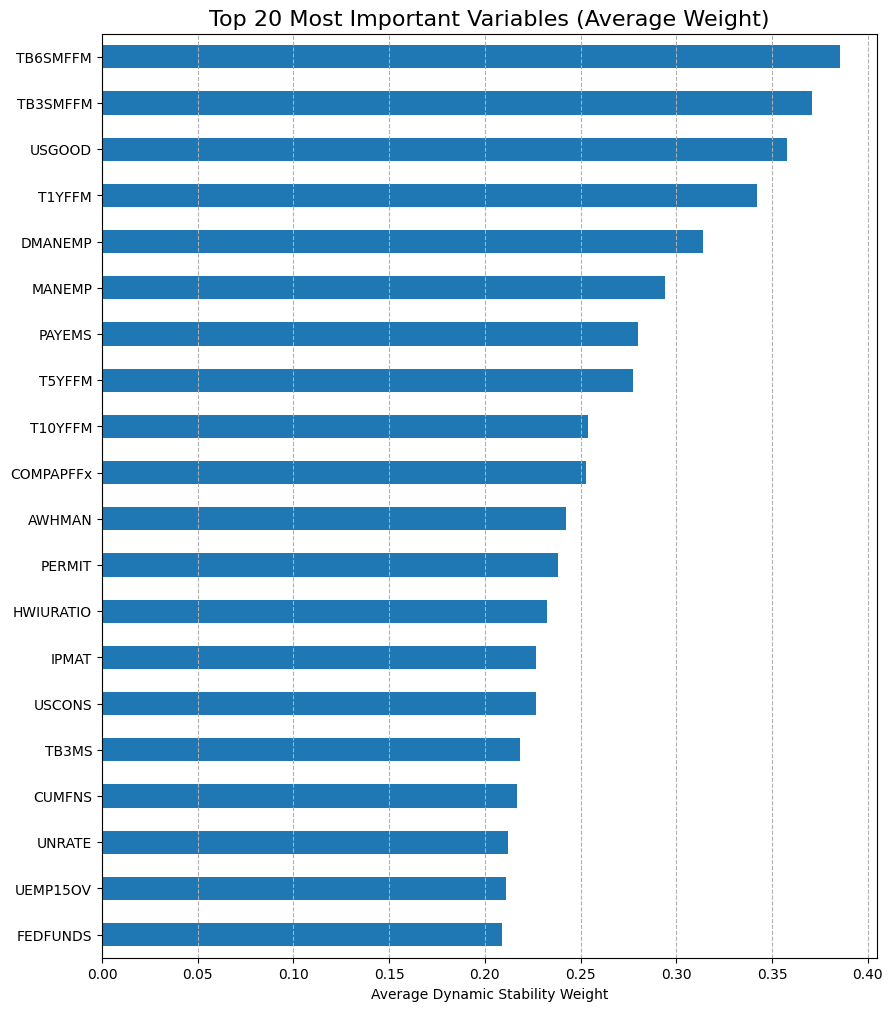

In [219]:
# weights for each variable, averaged over sample
avg_weights = avg_weights.groupby(level=0).mean()
top_20_vars = avg_weights.sort_values(ascending=False).head(20)

# Create the bar plot
plt.figure(figsize=(10, 12))
top_20_vars.sort_values().plot(kind='barh')
plt.title('Top 20 Most Important Variables (Average Weight)', fontsize=16)
plt.xlabel('Average Dynamic Stability Weight')
plt.grid(axis='x', linestyle='--')
plt.show()

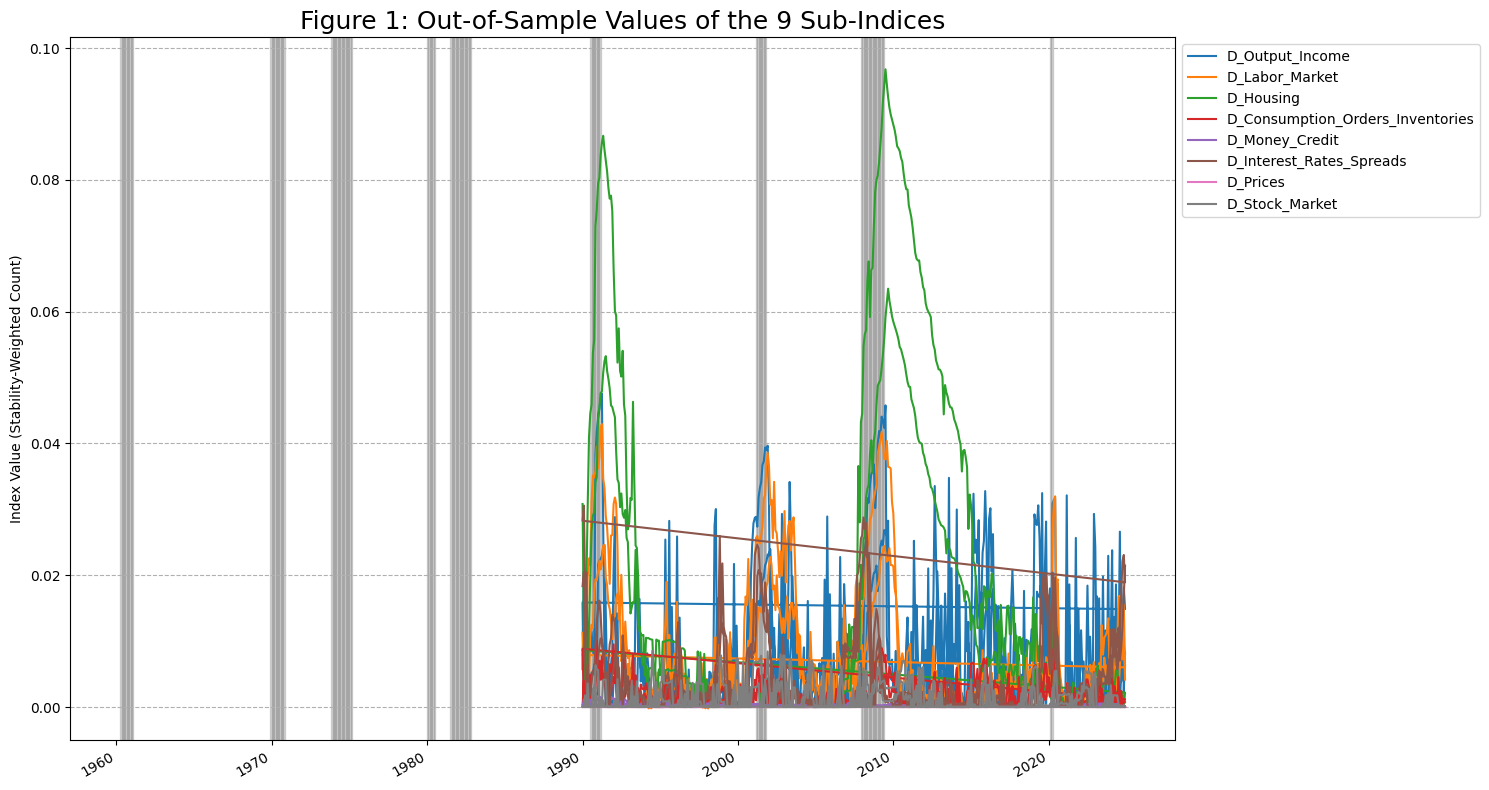

In [224]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- After your main forecasting loop is completely finished ---

# Concatenate the list of single-row DataFrames into one continuous time series
full_oos_deter_indices = pd.concat(oos_deter_indices_history)

# Load the actual recession dates for shading
recession_dates = y_target_full[y_target_full['USRECM'] == 1].index

# --- PLOT 1: The 9 Individual "Smart" Sub-Indices ---

fig1, ax1 = plt.subplots(figsize=(15, 8))

# Plot each of the 9 sub-indices
full_oos_deter_indices.plot(ax=ax1, legend=True)

# Shade the recession periods
for i in range(len(recession_dates) - 1):
    if (recession_dates[i+1] - recession_dates[i]).days < 60: # Handle contiguous periods
        ax1.axvspan(recession_dates[i], recession_dates[i+1], color='grey', alpha=0.3)

ax1.set_title('Figure 1: Out-of-Sample Values of the 9 Sub-Indices', fontsize=18)
ax1.set_ylabel('Index Value (Stability-Weighted Count)')
ax1.grid(axis='y', linestyle='--')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Move legend outside
plt.tight_layout()
plt.show()